# Intership Mindset Case 7 Graph Database #

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from flask import Flask, jsonify, request
from neo4j import GraphDatabase, basic_auth
from py2neo import Graph, Node, Relationship
from py2neo.matching import *
from py2neo.data import *
from yfiles_jupyter_graphs import *

## Sections ##

1. Loading dataset.


2. Determine the shape of dataset.


3. Dataset with three columns.


4. Find number of missing values in the dataset.


5. Create Graph Database.

     5.1 Import file with three columns.
     
     5.2  In neo4j browser run Cypher request to see event count per person.
     
     5.3 In neo4j bloom - top 3 persons.
     

6. yFiles graphs for Jupyter, Louvain algorithm and Label Propagation Community Detection algorithm.

     6.1. Creating a database connection driver.
     
     6.2. Execute Cypher query to load data from CSV and create nodes and relationships.
     
     6.3. Louvain algorithm.
     
     6.3.1. Create graph.
     
     6.3.2. Load the data from the CSV file.
     
     6.3.3. Adding nodes and edges.
     
     6.3.4. To apply the Louvain algorithm.
     
     6.3.5. Graph visualization.
     
     6.4. Label Propagation Community Detection algorithm.
     

7. Code uses the Cypher query language to match a Person node with the given name and all the events they participated in. It returns the subgraph in GraphML or JSON format, depending on the request.


8. Conlcusion.


9. Resources


## 1. Loading dataset. ##

In [3]:
df = pd.read_csv('mindset_data_test.csv')
df.head()

,id события;ФИО участника события 1;ФИО участника события 2
0,189;Галчевская Карина Владимировна;Белоновская...
1,206;Офицеров Олег Романович;Сапожник Борис Вал...
2,445;Жандарова Лариса Германовна;Чемодуров Дами...
3,503;Масимова Яна Дамировна;Мингажетдинов Рамил...
4,571;Мухтарова Алена Яковлевна;Щербатенко Ольга...


## 2. Determine the shape of dataset. ##

In [4]:
num_rows, num_cols = df.shape

print(f'CSV file has {num_cols} columns and {num_rows} rows')

CSV file has 1 columns and 5000 rows


  ## 3. Dataset with three columns. ##

In [5]:
df = pd.read_csv('mindset_data_test.csv')
new_cols = df['id события;ФИО участника события 1;ФИО участника события 2'].str.split(';', expand=True)
new_cols.columns = ['id события', 'ФИО участника события 1', 'ФИО участника события 2']
df = pd.concat([df, new_cols], axis=1)
df = df.drop('id события;ФИО участника события 1;ФИО участника события 2', axis=1)
print(df.head()) 


  id события         ФИО участника события 1          ФИО участника события 2
0        189  Галчевская Карина Владимировна  Белоновская Анастасия Семеновна
1        206         Офицеров Олег Романович        Сапожник Борис Валерьевич
2        445     Жандарова Лариса Германовна       Чемодуров Дамир Русланович
3        503          Масимова Яна Дамировна   Мингажетдинов Рамиль Семенович
4        571       Мухтарова Алена Яковлевна      Щербатенко Ольга Робертовна


## 4. Find number of missing values in the dataset. ##

In [6]:
df.isnull().sum()

id события                 0
ФИО участника события 1    0
ФИО участника события 2    0
dtype: int64

In [7]:
df

,id события,ФИО участника события 1,ФИО участника события 2
0,189,Галчевская Карина Владимировна,Белоновская Анастасия Семеновна
1,206,Офицеров Олег Романович,Сапожник Борис Валерьевич
2,445,Жандарова Лариса Германовна,Чемодуров Дамир Русланович
3,503,Масимова Яна Дамировна,Мингажетдинов Рамиль Семенович
4,571,Мухтарова Алена Яковлевна,Щербатенко Ольга Робертовна
...,...,...,...
4995,999333,Осташов Владимир Данилович,Чалов Илья Владимирович
4996,999360,Гандыбина Любовь Александровна,Мерлин Илья Юрьевич
4997,999403,Востоков Виктор Ильдарович,Аликас Никита Андреевич
4998,999405,Огарева Людмила Ильдаровна,Нагайцева Алина Степановна


## 5. Create Graph Database. ##

In [8]:
df.to_csv('cor_mindset_data_test.csv', index=False) # index = False , save file without index

## 5.1. Import file with three columns in database ##

![Screenshot_desktop_noe4j.png](Screenshot_desktop_noe4j.png)

## 5.2. In neo4j browser run Cypher request to see event count per person. ##

![Screenshot_Arhomeeva.png](Screenshot_Arhomeeva.png)

Ахромеева Алина is very active in community and have a great interest in the events, maybe a professional in the field related to these events and lookig for opportunities for learning(teaching), expanding her network or establishing business contacts. 

## 5.3 In neo4j bloom - top 3 persons. ##

![Screenshot_bloom.png](Screenshot_bloom.png)

The next Cypher request is to create graph where "Ахромеева Алина Ивановна" is a node and edges are "id события" and people who participated to event

![Screenshot_Alina.png](Screenshot_Alina.png)

## 6. yFiles graphs for Jupyter, Louvain algorithm and Label Propagation Community Detection algorithm. ##

## 6.1. Creating a database connection driver. ##

In [9]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "D@T@SCIENCE"


driver = GraphDatabase.driver(uri, auth=(user, password))

## 6.2. Execute Cypher query to load data from CSV and create nodes and relationships ##

This query loads data from a CSV file with headers, and creates the nodes and relationships into a Neo4j graph database. Specifically, it creates nodes for events and people, and creates a relationship between a person and an event indicating that the person participated in that event. The CSV file has three columns: event id, names of the first participant, and names of the second participant. The replace function is used to remove double quotes from the participant names. Finally, the query matches all the nodes with the PARTICIPATED_IN relationship, and returns the people, events, and relationships.

In [10]:
with driver.session(database ="neo4j") as session:
    graph = session.run("""
        LOAD CSV WITH HEADERS FROM "file:///cor_mindset_data_test.csv" AS row
        CREATE (e:Event {id: row.`id события`})
        CREATE (p1:Person {name: replace(row.`ФИО участника события 1`, '\"', '')})
        CREATE (p2:Person {name: replace(row.`ФИО участника события 2`, '\"', '')})
        CREATE (p1)-[:PARTICIPATED_IN {event_type: e.id}]->(e)
        CREATE (p2)-[:PARTICIPATED_IN {event_type: e.id}]->(e)
        WITH p1, p2, e
        MATCH (p:Person)-[r:PARTICIPATED_IN]->(e:Event)
        RETURN p, r, e LIMIT 300
    """).graph()
    
graph

In [11]:
GraphWidget(graph = graph) # renders neo4j graph, works with JupyterLab

GraphWidget(layout=Layout(height='500px', width='100%'))

In [12]:
#https://community.neo4j.com/t/neo4j-graph-visualization-in-jupyterlab/24219


#class GraphExample:
    #def __init__(self, uri, user, password):
        #self.driver = GraphDatabase.driver(uri, auth=(user,password))
        
    #def close(self):
        #self.driver.close()
        
    #def display(self, graph):
        #with self.driver.session() as session:
            #g = tx.run("MATCH (p:Person)-[r:PARTICIPATED_IN]->(e:Event) RETURN p, r, e LIMIT 300")
            #display(g)
#if __name__== "__main__":
    #graph = GraphExample("bolt://localhost:7687","neo4j","D@T@SCIENCE")
    #display(graph)
    #graph.close()  

## 6.3. Louvain algorithm. ##

The Louvain algorithm is a community detection algorithm that is based on modularity optimization. It works by initially assigning each node to its own community and then iteratively merging communities to maximize the modularity score. In each iteration, the algorithm goes through each node and considers moving it to a neighboring community that would increase the modularity score the most. The algorithm continues iterating until no further improvements in modularity can be made, and the resulting communities are output as the final solution. The Louvain algorithm is known for its efficiency and scalability, making it a popular choice for community detection in large graphs.

## 6.3.1. Create graph ##

In [13]:
G = nx.Graph()


## 6.3.2. Load the data from the CSV file ##

In [14]:
with open("cor_mindset_data_test.csv", "r") as f:
    next(f) # Skip header
    for line in f:
        row = line.strip().split(",")
        p1 = row[1].replace('"', '').strip() # ФИО участника сoбития 1
        p2 = row[2].replace('"', '').strip() # ФИО участника собития 2
        event_id = row[0].strip() 

## 6.3.3. Adding nodes and edges. ##

In [15]:
G.add_edge(p1, p2, event_type=event_id)

## 6.3.4. To apply the Louvain algorithm. ##

In [16]:
partition = greedy_modularity_communities(G)



## 6.3.5. Graph visualization. ##

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


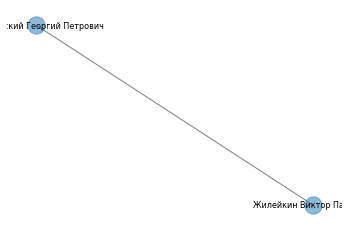

In [17]:
pos = nx.spring_layout(G, seed=42) # Positioning the nodes of graph
color_map = plt.cm.tab20
for i, comm_nodes in enumerate(partition):
    nx.draw_networkx_nodes(G, pos, nodelist=list(comm_nodes), node_color=color_map(i), alpha=0.5)
    # Add the names of the nodes
    labels = {}
    for node in comm_nodes:
        labels[node] = node
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)
plt.axis('off')
plt.show()


This can be interpreted as the fact that these two people have very strong relationships and their connections with the rest of the people in the graph are weaker

## 6.4. Label Propagation Community Detection algorithm. ##

The algorithm is based on the idea that nodes in a network tend to have similar labels if they are in the same community.

The Label propagation algorithm starts by assigning a unique label to each node in the network. Then, the labels of neighboring nodes are compared and the node updates its label to the most common label among its neighbors. This process is repeated iteratively until the labels of all nodes converge to a stable state

At the end of the algorithm, nodes with the same label are grouped together into communities. The algorithm is relatively fast and can be applied to large networks. However, it may not be as accurate as other community detection algorithms in some cases, particularly when communities have complex structures or when there are significant overlaps between communities.

In [18]:
# Load data from a CSV file
G = nx.Graph()
with open('cor_mindset_data_test.csv', 'r') as f:
    for line in f:
        cols = line.strip().split(',')
        node1 = cols[1].replace('"', '') # ФИО участника сoбития 1
        node2 = cols[2].replace('"', '') # ФИО участника собития 2
        G.add_edge(node1, node2)


In [19]:
# Finding communities with Label Propagation Community Detection
communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))

# Output the communities
for i, comm in enumerate(communities):
    print(f'Community {i+1}: {list(comm)}')

Community 1: ['ФИО участника события 1', 'ФИО участника события 2']
Community 2: ['Галчевская Карина Владимировна', 'Белоновская Анастасия Семеновна']
Community 3: ['Сапожник Борис Валерьевич', 'Офицеров Олег Романович']
Community 4: ['Жандарова Лариса Германовна', 'Чемодуров Дамир Русланович']
Community 5: ['Масимова Яна Дамировна', 'Мингажетдинов Рамиль Семенович']
Community 6: ['Щербатенко Ольга Робертовна', 'Мухтарова Алена Яковлевна']
Community 7: ['Федутинов Артем Артурович', 'Русских Кира Константиновна']
Community 8: ['Федонкина Кристина Маратовна', 'Маргиев Григорий Иванович']
Community 9: ['Чернолусская Екатерина Марселевна', 'Бухановская Лидия Радиковна']
Community 10: ['Скотников Виктор Ильич', 'Оранский Владимир Артурович']
Community 11: ['Ханыгин Дмитрий Юрьевич', 'Ардатов Андрей Анатольевич']
Community 12: ['Рифтин Кирилл Анатольевич', 'Гальчевская Полина Васильевна']
Community 13: ['Абушаева Екатерина Юрьевна', 'Балог Вадим Никитович']
Community 14: ['Бычек Виктор Рамил

## 7. Code uses the Cypher query language to match a Person node with the given name and all the events they participated in. It returns the subgraph in GraphML or JSON format, depending on the request. ##

In [20]:
# Connect to Neo4j database
uri = "bolt://localhost:7687"
user = "neo4j"
password = "password"
driver = GraphDatabase.driver(uri, auth=(user, password))

# Define Flask app
app = Flask(__name__)

# Define Cypher query to get the subgraph for a given name
# The subgraph includes the person node and all the events they participated in
query = """
MATCH (p:Person {name: $name})-[r]-(e:Event)
RETURN p, r, e
"""

# Define route for getting the subgraph for a given name in GraphML format
@app.route("/graphml/<name>")
def get_graphml(name):
    with driver.session() as session:
        result = session.run(query, name=name)
        graphml = result.graph().to_graphml()
    return Response(graphml, mimetype="application/xml")

# Define route for getting the subgraph for a given name in JSON format
@app.route("/json/<name>")
def get_json(name):
    with driver.session() as session:
        result = session.run(query, name=name)
        json_data = []
        for record in result:
            json_data.append({"person": record["p"], "relationship": record["r"], "event": record["e"]})
    return Response(json.dumps(json_data), mimetype="application/json")

## 8. Conlcusion. ##

As it became clear from 5.2. Ахромеева Алина and Башинина Антонина have the most participations in the events 50 and 14 respectively, which suggested that they would be one of the largest communities in the given data. The Louvain algorithm showed that two people have very strong relationships and their connections with the rest of the people in the graph are weaker, which is probably also due to the fact that in point 4. they are on the 4999th row, and in the result of the Label Propagation Community Detection algorithm they are in the last community 4910. We should note that community 223 the largest in the given dataset and 343 the second largest include Ахромеева Алина and Башинина Антонина, respectively, which is expected. Data analysis can be continued using GNN or algorithms from the Graph clustering family

## 9. Resources ##

https://neo4j.com/docs/operations-manual/current/installation/neo4j-browser/

https://neo4j.com/product/bloom/

https://towardsdatascience.com/louvain-algorithm-93fde589f58c

https://arxiv.org/pdf/0803.0476.pdf

https://neo4j.com/docs/graph-data-science/current/algorithms/label-propagation/

https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.label_propagation_communities.html

https://memgraph.com/blog/community-detection-algorithms-with-python-networkx
